## **Imports**

In [ ]:
!pip install mlflow --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 72.2 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 20.6 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 24.6 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.4 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 20.5 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 11.8 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.9 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00



In [4]:
!pip install gdown

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import cv2
import math
# import mlflow
# import mlflow.sklearn

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from struct import unpack
from tqdm import tqdm

2024-02-13 12:01:38.600672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 12:01:38.600777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 12:01:38.868337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
! unzip bag.zip

unzip:  cannot find or open bag.zip, bag.zip.zip or bag.zip.ZIP.


## **Utility Functions**

In [3]:
def eval_model_on_test(model, test_ds):

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(1000),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)
    if len(predictions[0]) > 1:
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = np.array(predictions)

    test_labels = np.array(test_labels)

    return test_labels, predictions

def plot_accuracy_loss(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']

    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    epochs_range = training_history.epoch

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy (Base)')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (Base)')
    plt.show()

def print_layer_trainable(model):
    """prints out layer names and if they are trainable or not of a given model"""

    print('trainable : layer name')
    print('- '*30)
    for layer in model.layers:
      # if layer.trainable:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

    return

def escape_fname(name):
    return name.replace('/','_')

def search_folder(folder_id, root):
    MAX_FILE_COUNT = 250
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    # file_list.count
    cnt = 0
    for file in file_list:
        cnt += 1
        if cnt > MAX_FILE_COUNT: #Stop creating files in the local directory if the number of files > MAX_FILE_COUNT
          break
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            prod_cat_foldername = file['title'].split('_')[0]
            prod_cat_folder = create_folder(root, prod_cat_foldername)
            class_foldername = escape_fname(file['title'])
            class_folder = create_folder(prod_cat_folder+'/', class_foldername)
            search_folder(file['id'], class_folder)
        else:
            # download_mimetype = None
            filename = escape_fname(file['title'])
            filename = '{}{}'.format(root+'/', filename)
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def create_folder(path,name):
    folder = '{}{}'.format(path,escape_fname(name))
    if not os.path.isdir(folder):
      print(f"Creating folder: {folder}")
      os.mkdir(folder)
    return folder

def search_processed_datasets_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            folder = create_folder(root+'/', file['title'])
            search_processed_datasets_folder(file['id'], root+'/'+file['title'])
        else:
            # download_mimetype = None
            filename = '{}{}'.format(root+'/', file['title'])
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def get_folder_info(folder_id):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    print(f'Number of folders/files in folder = {len(file_list)}')
    for file in file_list:
        if file['mimeType'].split('.')[-1] == 'folder':
            print(f"Folder Name = {file['title']}")
            get_folder_info(file['id'])
        else:
            pass

def create_base_model(activation, initializer, regularizer, dropout_rate, num_start_cnn_neurons=32, num_dense_neurons=256):
    model = tf.keras.Sequential([

      tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

      tf.keras.layers.Conv2D(filters=num_start_cnn_neurons, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Conv2D(filters=num_start_cnn_neurons*2, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Conv2D(filters=num_start_cnn_neurons*4, kernel_size=(3, 3), padding='same', activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense(num_dense_neurons, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer),
      tf.keras.layers.Dropout(rate=dropout_rate),

      tf.keras.layers.Dense(len(CLASSES), activation='softmax')

    ])
    return model

def create_resnet50_model(activation, initializer, regularizer, dropout_rate, num_dense_neurons=256):
    resnet_cnn_layers = tf.keras.applications.resnet50.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                include_top=False,
                                                weights='imagenet',
                                                )
    resnet_cnn_layers.trainable = False
    last_conv_layer_output = resnet_cnn_layers.get_layer('conv5_block3_out').output

    pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(last_conv_layer_output)

    # Custom classification layers
    dense_layer_1 = tf.keras.layers.Dense(num_dense_neurons, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer)(pooling_layer)
    dense_layer_dropout_1 = tf.keras.layers.Dropout(rate=dropout_rate)(dense_layer_1)
    output_layer = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(dense_layer_dropout_1)

    # Create a model with both convolutional and classification layers
    model = Model(inputs=resnet_cnn_layers.input, outputs=output_layer)

    return model

def get_mismatches(y_true, y_pred, BATCH_SIZE):
    num_mismatches = 0
    mismatch_tensor_indexes = {}
    for i in range(len(y_true)):
      if y_true[i] != y_pred[i]:
        num_mismatches += 1
        key = (i//BATCH_SIZE)
        tensor_index = (i % BATCH_SIZE)
        if mismatch_tensor_indexes.get(key) is not None:
          mismatch_tensor_indexes[key].append((tensor_index, i))
        else:
          mismatch_tensor_indexes[key] = [(tensor_index, i)]
    return num_mismatches, mismatch_tensor_indexes

def show_mismatches(test_ds, mismatch_tensor_indexes, num_mismatches):
    i=0
    total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
    tensor_batch = 0
    plt.figure(figsize=(15, (math.ceil(num_mismatches/30)*20)))
    for images, labels in test_ds.take(total_tensor_batches):
      if mismatch_tensor_indexes.get(tensor_batch) is not None:
        for tensor_batch_mismatches in mismatch_tensor_indexes.get(tensor_batch):
          ax = plt.subplot(math.ceil(num_mismatches/4), 4, i + 1)
          plt.imshow(images[tensor_batch_mismatches[0]].numpy().astype("uint8"))
          plt.title(f"Label=({labels[tensor_batch_mismatches[0]]},{y_true[tensor_batch_mismatches[1]]}), Pred={y_pred[tensor_batch_mismatches[1]]}")
          plt.axis("off")
          i += 1
      tensor_batch += 1

In [21]:
math.ceil(26/30)

1

## **Defining the GradCAM Class and Functions**

In [4]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):

        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):

        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8, verbose=False):

        # Step 1:
        # construct our gradient model by supplying
        # (1) the inputs to our pre-trained model
        # (2) the output of the (presumably) final 4D layer in the network
        # (3) the output of the softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        if verbose:
            print('\nStep 1:')
            print('Model:', self.model.name)
            print('Conv layerName:', self.layerName)
            print('Conv Layer Shape:', gradModel.outputs[0].shape)


        # Step 2:
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:

            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        if verbose:
            print('\nStep 2:')
            print('loss:', loss)
            print('convOutputs shape;', convOutputs.shape)
            print('gradients shape:', grads.shape)


        # Step 3:
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        if verbose:
            print('\nStep 3')
            print('guidedGrads shape', guidedGrads.shape)

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        if verbose:
            print('guidedGrads shape batch removal', guidedGrads.shape)
            print('convOutputs shape batch removal', convOutputs.shape)


        # Step 4:
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        if verbose:
            print('\nStep 4:')
            print('weights shape:', weights.shape)
            print('cam shape:', cam.shape)


        # Step 5:
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h),
                            interpolation=cv2.INTER_CUBIC)

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        if verbose:
            print('\nStep 5:')
            print('heatmap shape:', heatmap.shape)

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_JET):

        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

## **Step 0: If you have already created the Train, Validation and Test datasets and stored it in GDrive then you can skip Steps 2 and 3 (otherwise skip Step 0 and go to Step 2)**

In [ ]:
import gdown

url = 'https://drive.google.com/drive/folders/1--aFDGkp96RWChZHHrfh-w-mO0azqbgS'


In [5]:
# If the Tensor Dataset have already been created and are available in a Google drive,
# then you do not need to run the image loads and split the data into train, validation and test.
# You can directly load the tensor datasets from the  google drive to your local environment and use it

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
processed_datasets_folder_id = '1DZUC9VVBQ24xNsgFj-snz3ocRdmI-0xv'
bags_folder_id = ''
schuhe_folder_id = ''
waesche_folder_id = ''

root = './data/processed/bag'

if not os.path.isdir("./data"):
  os.mkdir('./data')

if not os.path.isdir("./data/processed"):
  os.mkdir('./data/processed')

if not os.path.isdir("./data/processed/bag"):
  os.mkdir('./data/processed/bag')

search_processed_datasets_folder(processed_datasets_folder_id, root)
f.close()

Creating folder: ./data/processed/bag/train_dataset

Creating folder: ./data/processed/bag/train_dataset/13566746268163081920

Creating folder: ./data/processed/bag/train_dataset/13566746268163081920/00000000.shard

Creating folder: ./data/processed/bag/train_dataset/6007611454123508922

Creating folder: ./data/processed/bag/train_dataset/6007611454123508922/00000000.shard

Creating folder: ./data/processed/bag/test_dataset

Creating folder: ./data/processed/bag/test_dataset/7675821213704089024

Creating folder: ./data/processed/bag/test_dataset/7675821213704089024/00000000.shard

Creating folder: ./data/processed/bag/test_dataset/1066113611490136018

Creating folder: ./data/processed/bag/test_dataset/1066113611490136018/00000000.shard

Creating folder: ./data/processed/bag/val_dataset

Creating folder: ./data/processed/bag/val_dataset/8589842609783317368

Creating folder: ./data/processed/bag/val_dataset/8589842609783317368/00000000.shard

Creating folder: ./data/processed/bag/val_dat

In [4]:
PRODUCT_CATEGORY = 'schuhe' # 'clothes'
GDRIVE_FOLDER = 'MyDrive/Best_Secret/data/processed'

IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above

# CLASSES = ['clothes_0_model_front'
#            , 'clothes_1_zoomed'
#            , 'clothes_2_model_back'
#            , 'clothes_3_ghost'
#            , 'clothes_4_look'
#            ]

CLASSES = ['schuhe_0_overall_to_right'
           , 'schuhe_1_back'
           , 'schuhe_2_top_or_soul'
           , 'schuhe_3_side_to_left'
           , 'schuhe_4_zoom'
           ]

train_ds = tf.data.Dataset.load(f'../input/schuhe-dataset/schuhe/train_dataset')
val_ds = tf.data.Dataset.load(f'../input/schuhe-dataset/schuhe/val_dataset')
test_ds = tf.data.Dataset.load(f'../input/schuhe-dataset/schuhe/test_dataset')

# train_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/train_dataset')
# val_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/val_dataset')
# test_ds = tf.data.experimental.load(f'/content/drive/{GDRIVE_FOLDER}/{PRODUCT_CATEGORY}/test_dataset')

In [5]:
classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
print("Class distribution in Train:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Train:
schuhe_0_overall_to_right occurs 155 times
schuhe_1_back occurs 166 times
schuhe_2_top_or_soul occurs 154 times
schuhe_3_side_to_left occurs 159 times
schuhe_4_zoom occurs 134 times


In [6]:
classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
print("Class distribution in Validation:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Validation:
schuhe_0_overall_to_right occurs 44 times
schuhe_1_back occurs 44 times
schuhe_2_top_or_soul occurs 54 times
schuhe_3_side_to_left occurs 45 times
schuhe_4_zoom occurs 69 times


In [6]:
classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
print("Class distribution in Test:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Test:
schuhe_0_overall_to_right occurs 49 times
schuhe_1_back occurs 35 times
schuhe_2_top_or_soul occurs 46 times
schuhe_3_side_to_left occurs 45 times
schuhe_4_zoom occurs 51 times


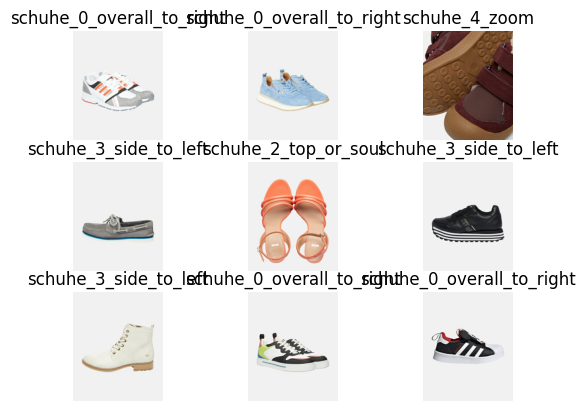

In [7]:
for images, labels in test_ds.take(2):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")


## **Spep 1: Loading a prebuilt model and using it to predict**

In [ ]:
# Load prebuilt and tuned models

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
processed_datasets_folder_id = '1JUgLVKtQinZkC79GIsnu6YwbAESWpntX'
bags_folder_id = ''
schuhe_folder_id = ''
waesche_folder_id = ''

root = './models'

if not os.path.isdir(root):
  os.mkdir(root)

search_processed_datasets_folder(processed_datasets_folder_id, root)
f.close()

In [ ]:
# Predict using the prebuilt model
from tensorflow.keras.models import load_model

# load model
model = load_model('./models/clothes_baseline_cnn_model.h5')

y_true, y_pred = eval_model_on_test(model, test_ds)
score = (accuracy_score(y_true, y_pred)*100)
print("\n\nAccuracy of base model on test data: %.2f%%" % score)
print(classification_report(y_true, y_pred)) #, target_names=CLASSES
print(pd.DataFrame(confusion_matrix(y_true, y_pred)))

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 138ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:00<00:02,  2.66it/s]

1/1 [==============================] - 0s 74ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:00<00:01,  4.03it/s]

1/1 [==============================] - 0s 79ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:00<00:01,  4.81it/s]

1/1 [==============================] - 0s 71ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:00<00:00,  5.17it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:01<00:00,  5.52it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:01<00:00,  5.75it/s]

1/1 [==============================] - 0s 71ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:01<00:00,  5.94it/s]

1/1 [==============================] - 0s 117ms/step


Predicting on Test Data: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]





Accuracy of base model on test data: 88.26%

              precision    recall  f1-score   support



           0       0.73      0.80      0.77        51

           1       0.95      0.98      0.97        58

           2       0.78      0.63      0.70        46

           3       1.00      0.98      0.99        43

           4       0.94      1.00      0.97        49



    accuracy                           0.88       247

   macro avg       0.88      0.88      0.88       247

weighted avg       0.88      0.88      0.88       247



    0   1   2   3   4

0  41   1   8   0   1

1   1  57   0   0   0

2  14   2  29   0   1

3   0   0   0  42   1

4   0   0   0   0  49


## **Step 2: Importing the Image data from Google drive**

**Note:** we figured out how to download a nested folder structure allong with the files from Google Drive (instead of just one file) from the following StackOverflow discussion - https://stackoverflow.com/questions/46155300/pydrive-error-no-downloadlink-exportlinks-for-mimetype-found-in-metadata

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
# folder_id = '17NfTjPmDwCB5WO3FgM83Bmgdc631e8Ac' # Folder ID for image_data folder in Best Secrets GDrive (/Best Secret/Data/image_data)
# folder_id = '1Dw7Ae8--BC0I5ROvg36sZB9nZSsGQnyv' # Folder ID for data_not_cleaned folder in Best Secrets GDrive (/Best Secret/Data/data_not_cleaned)
folder_id = '1K4kDGdtemeve34GYPxafygtzSzS-8GTm' # Folder ID for the cleaned Bag images

# Note: these folders should match the final project folder structure we create and may need to be updated
root = './data/raw'
# If the folders that we want to download the images to do not exit then create them as shown below:
if not os.path.isdir("./data"):
  os.mkdir('./data')

if not os.path.isdir("./data/raw"):
  os.mkdir('./data/raw')

search_folder(folder_id,root+'/')
f.close()

Creating folder: ./data/raw/bag

Creating folder: ./data/raw/bag/bag_4

Creating folder: ./data/raw/bag/bag_3

Creating folder: ./data/raw/bag/bag_2

Creating folder: ./data/raw/bag/bag_1

Creating folder: ./data/raw/bag/bag_0


In [7]:
get_folder_info(folder_id)

Number of folders/files in folder = 5

Folder Name = bag_4

Number of folders/files in folder = 258

Folder Name = bag_3

Number of folders/files in folder = 250

Folder Name = bag_2

Number of folders/files in folder = 250

Folder Name = bag_1

Number of folders/files in folder = 250

Folder Name = bag_0

Number of folders/files in folder = 250


##**Step 3: Load image data and split them into Train, Validation and Test**

### **Step 3.1: Process the data from Step 2:**

**Note:** there is a script we can run to find corrupted images. We ran this script and found an image (./image_data/raw/clothes/clothes_1_zoomed/32760559-001.jpg') that was corrupted and deleted it from the directory so it does not cause issues down stream when we train our models

In [8]:
import pathlib
root = './data/raw'
data_dir = pathlib.Path(root)
data_dir

PosixPath('data/raw')

In [9]:
!sudo apt-get install tree

Reading package lists... Done

Building dependency tree... Done

Reading state information... Done

The following NEW packages will be installed:

  tree

0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.

Need to get 47.9 kB of archives.

After this operation, 116 kB of additional disk space will be used.

Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]

Fetched 47.9 kB in 1s (55.4 kB/s)

debconf: unable to initialize frontend: Dialog

debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)

debconf: falling back to frontend: Readline

debconf: unable to initialize frontend: Readline

debconf: (This frontend requires a controlling tty.)

debconf: falling back to frontend: Teletype

dpkg-preconfigure: unable to re-open stdin: 

Selecting previously unselected package tree.

(Reading database ... 121747 files and directorie

In [10]:
!tree --dirsfirst --filelimit 6 './data/raw'

./data/raw

└── bag

    ├── bag_0  [250 entries exceeds filelimit, not opening dir]

    ├── bag_1  [250 entries exceeds filelimit, not opening dir]

    ├── bag_2  [250 entries exceeds filelimit, not opening dir]

    ├── bag_3  [250 entries exceeds filelimit, not opening dir]

    └── bag_4  [250 entries exceeds filelimit, not opening dir]



6 directories, 0 files


In [11]:
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f"Total number of images across all categories and classes = {image_count}")

Total number of images across all categories and classes = 1250


In [13]:
bag_0 = list(data_dir.glob('bag/bag_0/*.jpg'))

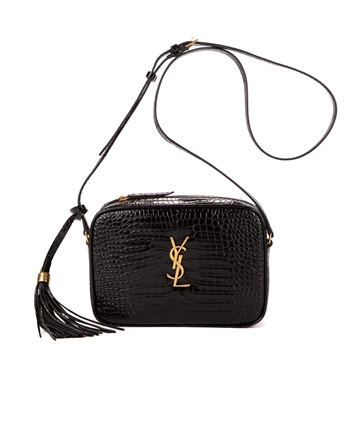

In [14]:
PIL.Image.open(str(bag_0[4]))

In [15]:
from struct import unpack
from tqdm import tqdm
import os

marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()

    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]
            if len(data)==0:
                raise TypeError("issue reading jpeg file")

bads = []

img_dir = root

for dirName, subdirList, fileList in os.walk(img_dir):
    imagesList = fileList
    for img in tqdm(imagesList):
        image = os.path.join(dirName,img)
        image = JPEG(image)
        try:
            image.decode()
        except:
            bads.append(dirName+'/'+img)

#Show the bad images
bads

#remove the bad images
# note: we found the following image that was corrupted that we removed - ./raw/clothes/clothes_1_zoomed/32760559-001.jpg'
# for name in bads:
#   os.remove(name)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

100%|██████████| 250/250 [00:00<00:00, 23122.87it/s]

100%|██████████| 250/250 [00:00<00:00, 25089.15it/s]

100%|██████████| 250/250 [00:00<00:00, 22432.31it/s]

100%|██████████| 250/250 [00:00<00:00, 16870.34it/s]

100%|██████████| 250/250 [00:00<00:00, 19272.46it/s]


[]

**The script above found one corrupted image in the clothes_1_zoomed folder - './data/raw/clothes/clothes_1_zoomed/32760559-001.jpg'**

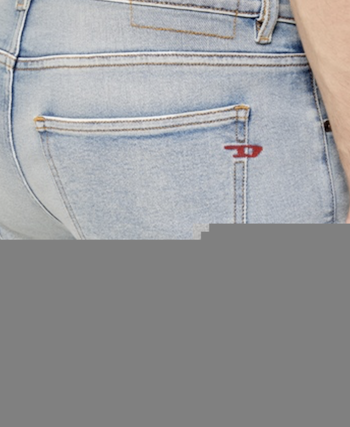

In [16]:
bads

[]

In [17]:
# Delete the corrupted image from the folder
for name in bads:
  os.remove(name)

In [18]:
# Image count after deleting the corrupted image
image_count = len(list(data_dir.glob('*/*/*.jpg')))
print(f"Total number of images across all categories and classes = {image_count}")

Total number of images across all categories and classes = 1250


### **Step 3.2: Split data into Train, Validatin and Test**

In [19]:
RANDOM_SEED = 42
#VAL_SPLIT = 0.4
PRODUCT_CATEGORY = 'bag' # 'waesche' 'schuhe' 'clothes'
BATCH_SIZE = 32
IMG_HEIGHT = 427 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
IMG_WIDTH = 350 # change this to the appropriate size based on the PRODUCT_CATEGORY selected above
SHUFFLE = True

PROD_DATA_DIR = pathlib.Path(root+'/'+PRODUCT_CATEGORY)
CLASSES = [PRODUCT_CATEGORY+'_0'
           , PRODUCT_CATEGORY+'_1'
           , PRODUCT_CATEGORY+'_2'
           , PRODUCT_CATEGORY+'_3'
           , PRODUCT_CATEGORY+'_4'
           ]

# This code gives the classes
# for item in os.scandir(PROD_DATA_DIR):
#     if not item.name.startswith('.'): #dont include any hidden files or dirs that may be in the folder (more applicable when running on local machine)
#         CLASSES.append(item.name)

In [20]:
CLASSES

['bag_0', 'bag_1', 'bag_2', 'bag_3', 'bag_4']

In [22]:
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory = PROD_DATA_DIR,
  seed=RANDOM_SEED,
  class_names=CLASSES,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  shuffle = SHUFFLE)

ds_batches = tf.data.experimental.cardinality(full_ds)
train_ds = full_ds.take(((ds_batches) * 3) // 5) #60% of the data for training
val_test_ds = full_ds.skip(((ds_batches) * 3) // 5) #40% of the remaining data for validation and test

val_test_batches = tf.data.experimental.cardinality(val_test_ds)
val_ds = val_test_ds.take((val_test_batches) // 2) #50% of the val_test_ds for validation (20% of full_ds)
test_ds = val_test_ds.skip((val_test_batches) // 2) #50% of the val_test_ds for Test (20% of full_ds)

print(f'Train data size = {len(train_ds)*BATCH_SIZE}')
print(f'Validation data size = {len(val_ds)*BATCH_SIZE}')
print(f'Test data size = {len(test_ds)*BATCH_SIZE}')

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   directory = PROD_DATA_DIR,
#   validation_split=VAL_SPLIT,
#   subset="validation",
#   seed=RANDOM_SEED,
#   class_names=CLASSES,
#   image_size=(IMG_HEIGHT, IMG_WIDTH),
#   batch_size=BATCH_SIZE,
#   shuffle = SHUFFLE)

Found 1250 files belonging to 5 classes.

Train data size = 768

Validation data size = 256

Test data size = 256


In [23]:
classes, class_count = np.unique(np.concatenate([y for x, y in train_ds], axis=0), return_counts=True)
print("Class distribution in Train:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Train:

bag_0 occurs 145 times

bag_1 occurs 164 times

bag_2 occurs 159 times

bag_3 occurs 161 times

bag_4 occurs 139 times


In [24]:
classes, class_count = np.unique(np.concatenate([y for x, y in val_ds], axis=0), return_counts=True)
print("Class distribution in Validation:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Validation:

bag_0 occurs 49 times

bag_1 occurs 49 times

bag_2 occurs 49 times

bag_3 occurs 45 times

bag_4 occurs 64 times


In [25]:
classes, class_count = np.unique(np.concatenate([y for x, y in test_ds], axis=0), return_counts=True)
print("Class distribution in Test:")
for value, count in zip(classes, class_count):
    print(f"{CLASSES[value]} occurs {count} times")

Class distribution in Test:

bag_0 occurs 47 times

bag_1 occurs 39 times

bag_2 occurs 51 times

bag_3 occurs 39 times

bag_4 occurs 50 times


### **Step 3.3: Save the Train, Val and Test tensor datasets so it can saved in a Google Drive to be used later. That way we dont have to download all images again and it is muh faster to train a new model with the same data (refer to Step 0)**

In [27]:
if not os.path.isdir("./data/processed"):
  os.mkdir('./data/processed')

if not os.path.isdir("./data/processed/"+PRODUCT_CATEGORY):
  os.mkdir("./data/processed/"+PRODUCT_CATEGORY)

tf.data.Dataset.save(train_ds, './data/processed/'+PRODUCT_CATEGORY+'/train_dataset')
tf.data.Dataset.save(val_ds, './data/processed/'+PRODUCT_CATEGORY+'/val_dataset')
tf.data.Dataset.save(test_ds, './data/processed/'+PRODUCT_CATEGORY+'/test_dataset')

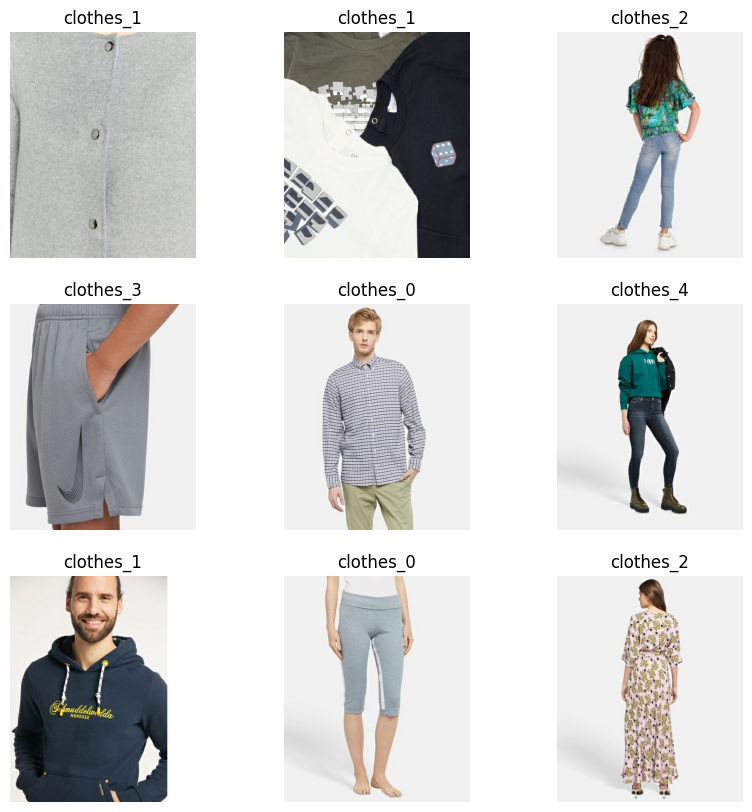

In [ ]:
# Check that the label and images match
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

## **Step 4: Create, Train, Validate and Test models**

In [9]:
# Test out different hyper-parameters

ACTIVATIONS = ['leaky_relu'
              #  , 'relu'
              #  , 'elu'
              #  , 'tanh'
              #  , 'selu'
              ]
INITIALIZERS = ['glorot_uniform'
                # , 'glorot_normal'
                # , 'he_normal'
                # , 'lecun_normal'
               ]


KERNEL_REGULARIZERS = [ None
                      #  , 'l1'
                      #  , 'l2'
                      #  , 'l1_l2'
                      ]

DROPOUT_RATE = [0.0
                # , 0.05
                # , 0.1
                # , 0.2
                # , 0.25
                ]
NUM_START_CNN_NEURONS = [32]
NUM_DENSE_NEURONS = [256]

EPOCHS = 20
BATCH_SIZE = 32
INITIAL_LEARNING_RATE = 0.001
FINAL_LEARNING_RATE = 0.00001
LEARNING_RATE_DECAY_FACTOR = (FINAL_LEARNING_RATE / INITIAL_LEARNING_RATE)**(1/EPOCHS)
STEPS_PER_EPOCH = len(train_ds) # this should actually be set to int(train_size/batch_size), but since the len(train_ds) returns the number of training records divided by the batch size already we just set it to that


In [10]:
# The caching helps speed up training after the first batch as the data is pulled from the cache for subsequent batches
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Step 4.1: Baseline CNN model**

**Hyper Parameter Tuning Results:**
1. Choosing the best Activation function:

| Activation | Initializer | Regularizer | Dropout | CNN_Start_Neurons | Dense_Neurons | Accuracy_Score |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  relu   |  glorot_uniform   |  None   |  0.0   |  32   |  256   |  88.938053   |
|  **leaky_relu**   |  glorot_uniform   |  None  |  0.0   |  32   |  256   |  **90.265487**   |
|  elu   |  glorot_uniform  |  None   |  0.0   |  32   |  256   |  86.725664   |
|  tanh   |  glorot_uniform   |  None  |  0.0   |  32   |  256   |  30.973451   |
|  selu   |  glorot_uniform  |  None   |  0.0   |  32   |  256   |  81.415929   |

2. Choosing the best Initializer function:

| Activation | Initializer | Regularizer | Dropout | CNN_Start_Neurons | Dense_Neurons | Accuracy_Score |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  **leaky_relu**    |  **glorot_uniform**   |  None   |  0.0   |  32   |  256   |  **89.380531**   |
|  leaky_relu   |  glorot_normal   |  None  |  0.0   |  32   |  256   |  88.053097   |
|  leaky_relu    |  he_normal  |  None   |  0.0   |  32   |  256   |  84.955752   |
|  leaky_relu    |  lecun_normal   |  None  |  0.0   |  32   |  256   |  86.725664   |





1. Training model with activation = leaky_relu, initializer = glorot_uniform, regulizer = None,  dropout_rate=0.0, num_start_cnn_neurons=32 and num_dense_neurons=256


Epoch 1/20

24/24 [==============================] - ETA: 0s - loss: 9.4053 - accuracy: 0.4635

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


24/24 [==============================] - 17s 353ms/step - loss: 9.4053 - accuracy: 0.4635 - val_loss: 0.7556 - val_accuracy: 0.6836

Epoch 2/20

24/24 [==============================] - 7s 301ms/step - loss: 0.6097 - accuracy: 0.7865 - val_loss: 0.5445 - val_accuracy: 0.7812

Epoch 3/20

24/24 [==============================] - 7s 313ms/step - loss: 0.3930 - accuracy: 0.8581 - val_loss: 0.3756 - val_accuracy: 0.8789

Epoch 4/20

24/24 [==============================] - 7s 314ms/step - loss: 0.2963 - accuracy: 0.8906 - val_loss: 0.3344 - val_accuracy: 0.8945

Epoch 5/20

24/24 [==============================] - 5s 199ms/step - loss: 0.2422 - accuracy: 0.9115 - val_loss: 0.3808 - val_accuracy: 0.8672

Epoch 6/20

24/24 [==============================] - 7s 317ms/step - loss: 0.2631 - accuracy: 0.9010 - val_loss: 0.3069 - val_accuracy: 0.8828

Epoch 7/20

24/24 [==============================] - 7s 309ms/step - loss: 0.2447 - accuracy: 0.9036 - val_loss: 0.2531 - val_accuracy: 0.9141

Epo

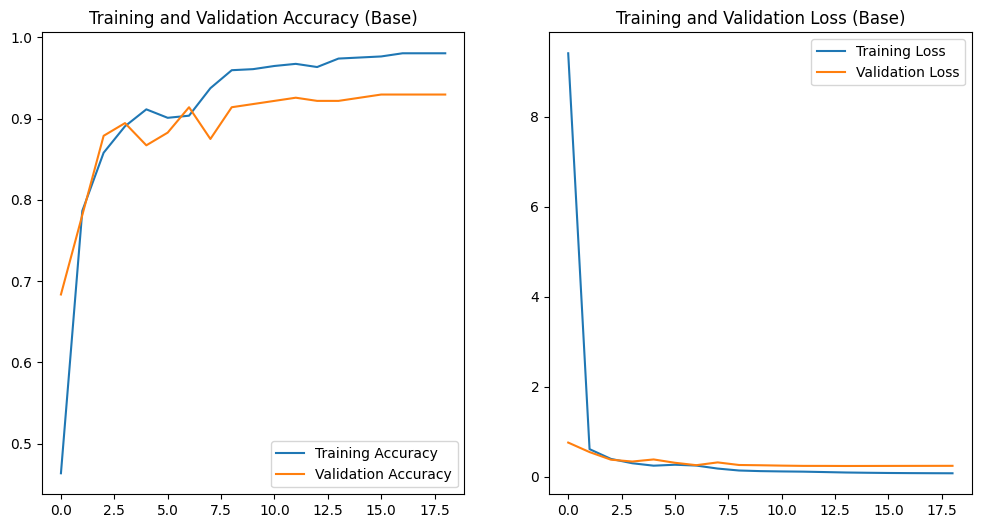

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 0s 169ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:00<00:03,  2.32it/s]

1/1 [==============================] - 0s 73ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:00<00:01,  3.59it/s]

1/1 [==============================] - 0s 74ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:00<00:01,  4.36it/s]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:00<00:00,  4.82it/s]

1/1 [==============================] - 0s 72ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:01<00:00,  4.89it/s]

1/1 [==============================] - 0s 70ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:01<00:00,  5.15it/s]

1/1 [==============================] - 0s 71ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:01<00:00,  5.35it/s]

1/1 [==============================] - 0s 386ms/step


Predicting on Test Data: 100%|██████████| 8/8 [00:01<00:00,  4.15it/s]





Accuracy of base model on test data: 88.50%

              precision    recall  f1-score   support



           0       0.90      0.80      0.85        45

           1       0.88      0.78      0.83        46

           2       0.80      0.86      0.83        37

           3       0.84      0.95      0.89        43

           4       0.98      1.00      0.99        55



    accuracy                           0.88       226

   macro avg       0.88      0.88      0.88       226

weighted avg       0.89      0.88      0.88       226



    0   1   2   3   4

0  36   2   1   6   0

1   1  36   7   1   1

2   1   3  32   1   0

3   2   0   0  41   0

4   0   0   0   0  55



Activation     Initializer Regularizer  Dropout  CNN_Start_Neurons  \
0  leaky_relu  glorot_uniform        None      0.0                 32   

   Dense_Neurons  Accuracy_Score  
0            256       88.495575

In [13]:
training_results_df = pd.DataFrame(columns=['Activation', 'Initializer', 'Regularizer', 'Dropout', 'CNN_Start_Neurons', 'Dense_Neurons', 'Accuracy_Score'])

i=0
# with mlflow.start_run():
    # mlflow.sklearn.autolog()
for activation in ACTIVATIONS:
    for initializer in INITIALIZERS:
        for regularizer in KERNEL_REGULARIZERS:
            for dropout_rate in DROPOUT_RATE:
                for num_start_cnn_neurons in NUM_START_CNN_NEURONS:
                    for num_dense_neurons in NUM_DENSE_NEURONS:
                        print(f'\n\n{i+1}. Training model with activation = {activation}, initializer = {initializer}, regulizer = {regularizer},  dropout_rate={dropout_rate}, num_start_cnn_neurons={num_start_cnn_neurons} and num_dense_neurons={num_dense_neurons}')
                        print("="*80)

                        model_base = create_base_model(activation, initializer, regularizer, dropout_rate, num_start_cnn_neurons, num_dense_neurons)

                        LR_SCHEDULE = tf.keras.optimizers.schedules.ExponentialDecay(
                            initial_learning_rate = INITIAL_LEARNING_RATE,
                            decay_steps = STEPS_PER_EPOCH,
                            decay_rate=LEARNING_RATE_DECAY_FACTOR,
                            staircase=True)

                        model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_SCHEDULE),
                                      loss="sparse_categorical_crossentropy",
                                      metrics=['accuracy'])

                        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
                        checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_baseline_cnn_model.h5", save_best_only=True)

                        history_base = model_base.fit(
                                        x=train_ds,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        verbose="auto",
                                        callbacks=[early_stopping_cb, checkpoint_cb],
                                        validation_data=val_ds
                                        # class_weight=None,
                                        # sample_weight=None,
                                        # initial_epoch=0,
                                        # steps_per_epoch=None,
                                        # validation_steps=None,
                                        # validation_batch_size=None,
                                        # validation_freq=1,
                                    )

                        plot_accuracy_loss(history_base)

                        y_true, y_pred = eval_model_on_test(model_base, test_ds)
                        score = (accuracy_score(y_true, y_pred)*100)
                        print("\n\nAccuracy of base model on test data: %.2f%%" % score)
                        print(classification_report(y_true, y_pred)) #, target_names=CLASSES
                        print(pd.DataFrame(confusion_matrix(y_true, y_pred)))

                        new_row = {'Activation' : activation, 'Initializer' : initializer, 'Regularizer': regularizer, 'Dropout' : dropout_rate, 'CNN_Start_Neurons' : num_start_cnn_neurons, 'Dense_Neurons' : num_dense_neurons, 'Accuracy_Score' : score}
                        training_results_df.loc[len(training_results_df)] = new_row
                        i += 1

print("="*80)
training_results_df

In [18]:
training_results_df

Activation     Initializer Regularizer  Dropout  CNN_Start_Neurons  \
0  leaky_relu  glorot_uniform        None      0.0                 32   
1  leaky_relu   glorot_normal        None      0.0                 32   
2  leaky_relu       he_normal        None      0.0                 32   
3  leaky_relu    lecun_normal        None      0.0                 32   

   Dense_Neurons  Accuracy_Score  
0            256       89.380531  
1            256       88.053097  
2            256       84.955752  
3            256       86.725664

In [15]:
pd.DataFrame(confusion_matrix(y_true, y_pred))

0   1   2   3   4
0  36   2   1   6   0
1   1  36   7   1   1
2   1   3  32   1   0
3   2   0   0  41   0
4   0   0   0   0  55

In [16]:
num_mismatches, mismatch_tensor_indexes = get_mismatches(y_true, y_pred, BATCH_SIZE)
print(f"Number of mismatches = {num_mismatches}")
mismatch_tensor_indexes

Number of mismatches = 26


{0: [(16, 16)],
 1: [(0, 32), (5, 37), (17, 49), (30, 62)],
 2: [(13, 77), (18, 82), (20, 84), (23, 87), (27, 91)],
 3: [(22, 118), (28, 124)],
 4: [(7, 135), (13, 141), (21, 149), (26, 154)],
 5: [(7, 167), (8, 168), (12, 172), (16, 176), (24, 184), (27, 187)],
 6: [(3, 195), (13, 205), (21, 213)],
 7: [(0, 224)]}

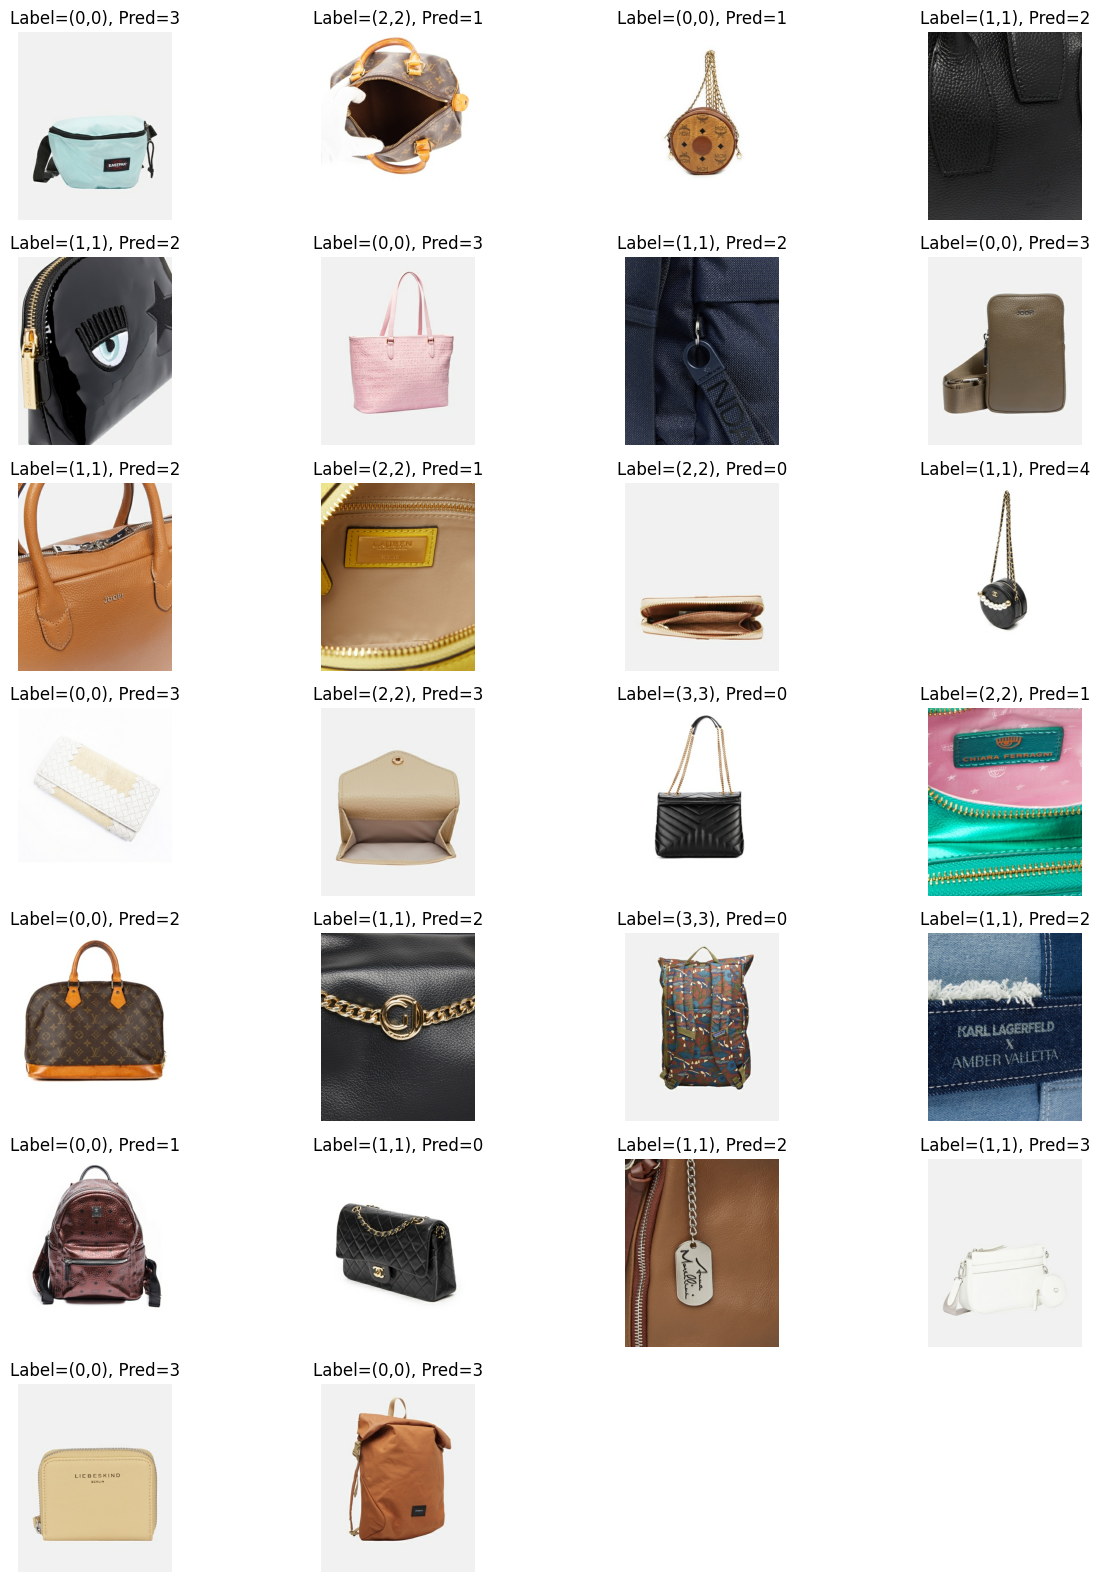

In [24]:
show_mismatches(test_ds, mismatch_tensor_indexes, num_mismatches)

In [ ]:
# Run this only if you want to see ALL test images with label and prediction

# import math
# i=0
# total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
# plt.figure(figsize=(15, 200))
# for images, labels in test_ds.take(total_tensor_batches):
#   for j in range(len(labels)):
#     # print(f'{i}, {j}')
#     ax = plt.subplot(math.ceil(len(y_pred)/5), 5, i + 1)
#     plt.imshow(images[j].numpy().astype("uint8"))
#     plt.title(f"Label={labels[j]}, Pred={y_pred[i]}")
#     plt.axis("off")
#     i += 1

In [ ]:
model_base.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 rescaling (Rescaling)       (None, 427, 350, 3)       0         

                                                                 

 conv2d (Conv2D)             (None, 427, 350, 32)      896       

                                                                 

 max_pooling2d (MaxPooling2  (None, 213, 175, 32)      0         

 D)                                                              

                                                                 

 dropout (Dropout)           (None, 213, 175, 32)      0         

                                                                 

 conv2d_1 (Conv2D)           (None, 213, 175, 64)      18496     

                                                                 

 max_pooling2d_1 (MaxPoolin  (None, 106, 87, 64)       0         

 g2D)                                   

### **Step 4.2: ResNet50 Model (no finetunning of CNN layers, just the Dense layers)** **bold text**



1. Training model with activation = leaky_relu, initializer = glorot_uniform, regulizer = None,  dropout_rate=0.0, num_start_cnn_neurons=32 and num_dense_neurons=256
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/20


I0000 00:00:1707821363.680732     150 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - ETA: 0s - loss: 0.8513 - accuracy: 0.7005

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 21s 431ms/step - loss: 0.8513 - accuracy: 0.7005 - val_loss: 0.4750 - val_accuracy: 0.8398
Epoch 2/20
24/24 [==============================] - 9s 382ms/step - loss: 0.3150 - accuracy: 0.8828 - val_loss: 0.3444 - val_accuracy: 0.8945
Epoch 3/20
24/24 [==============================] - 9s 359ms/step - loss: 0.2352 - accuracy: 0.9245 - val_loss: 0.3451 - val_accuracy: 0.8867
Epoch 4/20
24/24 [==============================] - 9s 393ms/step - loss: 0.2041 - accuracy: 0.9258 - val_loss: 0.2968 - val_accuracy: 0.9102
Epoch 5/20
24/24 [==============================] - 9s 366ms/step - loss: 0.1596 - accuracy: 0.9531 - val_loss: 0.3005 - val_accuracy: 0.9062
Epoch 6/20
24/24 [==============================] - 9s 371ms/step - loss: 0.1307 - accuracy: 0.9688 - val_loss: 0.3039 - val_accuracy: 0.8945
Epoch 7/20
24/24 [==============================] - 10s 400ms/step - loss: 0.1209 - accuracy: 0.9727 - val_loss: 0.2968 - val_accuracy: 0.9023
Epoch 8/20
24/2

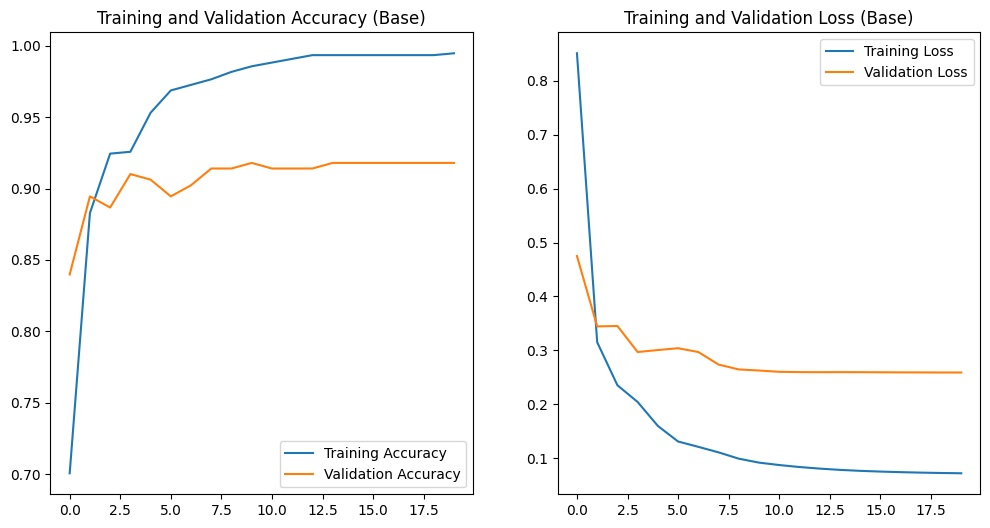

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:01<00:11,  1.57s/it]

1/1 [==============================] - 0s 83ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:01<00:05,  1.14it/s]

1/1 [==============================] - 0s 83ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:03,  1.54it/s]

1/1 [==============================] - 0s 79ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:02<00:02,  1.84it/s]

1/1 [==============================] - 0s 81ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:03<00:01,  2.07it/s]

1/1 [==============================] - 0s 80ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:03<00:00,  2.19it/s]

1/1 [==============================] - 0s 79ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:03<00:00,  2.31it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]



Accuracy of base model on test data: 92.04%
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        49
           1       1.00      1.00      1.00        35
           2       0.98      0.91      0.94        46
           3       0.81      0.93      0.87        45
           4       0.98      0.88      0.93        51

    accuracy                           0.92       226
   macro avg       0.93      0.93      0.93       226
weighted avg       0.93      0.92      0.92       226

    0   1   2   3   4
0  44   0   0   4   1
1   0  35   0   0   0
2   0   0  42   4   0
3   2   0   1  42   0
4   4   0   0   2  45


Activation     Initializer Regularizer  Dropout  Dense_Neurons  \
0  leaky_relu  glorot_uniform        None      0.0            256   

   Accuracy_Score  
0       92.035398

In [9]:
training_results_df = pd.DataFrame(columns=['Activation', 'Initializer', 'Regularizer', 'Dropout', 'Dense_Neurons', 'Accuracy_Score'])

resnet_model = None
i=0
# with mlflow.start_run():
    # mlflow.sklearn.autolog()
for activation in ACTIVATIONS:
    for initializer in INITIALIZERS:
        for regularizer in KERNEL_REGULARIZERS:
            for dropout_rate in DROPOUT_RATE:
                for num_start_cnn_neurons in NUM_START_CNN_NEURONS:
                    for num_dense_neurons in NUM_DENSE_NEURONS:
                        print(f'\n\n{i+1}. Training model with activation = {activation}, initializer = {initializer}, regulizer = {regularizer},  dropout_rate={dropout_rate}, num_start_cnn_neurons={num_start_cnn_neurons} and num_dense_neurons={num_dense_neurons}')
                        print("="*80)

                        resnet_model = create_resnet50_model(activation, initializer, regularizer, dropout_rate, num_dense_neurons)

                        LR_SCHEDULE = tf.keras.optimizers.schedules.ExponentialDecay(
                            initial_learning_rate = INITIAL_LEARNING_RATE,
                            decay_steps = STEPS_PER_EPOCH,
                            decay_rate=LEARNING_RATE_DECAY_FACTOR,
                            staircase=True)

                        resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_SCHEDULE),
                                      loss="sparse_categorical_crossentropy",
                                      metrics=['accuracy'])
                        resnet_model.layers[1].trainable = False

                        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
                        checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_resnet50_model.h5", save_best_only=True)

                        history_base = resnet_model.fit(
                                        x=train_ds,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        verbose="auto",
                                        callbacks=[early_stopping_cb, checkpoint_cb],
                                        validation_data=val_ds
                                        # class_weight=None,
                                        # sample_weight=None,
                                        # initial_epoch=0,
                                        # steps_per_epoch=None,
                                        # validation_steps=None,
                                        # validation_batch_size=None,
                                        # validation_freq=1,
                                    )

                        plot_accuracy_loss(history_base)

                        y_true, y_pred = eval_model_on_test(resnet_model, test_ds)
                        score = (accuracy_score(y_true, y_pred)*100)
                        print("\n\nAccuracy of base model on test data: %.2f%%" % score)
                        print(classification_report(y_true, y_pred)) #, target_names=CLASSES
                        print(pd.DataFrame(confusion_matrix(y_true, y_pred)))

                        new_row = {'Activation' : activation, 'Initializer' : initializer, 'Regularizer': regularizer, 'Dropout' : dropout_rate, 'Dense_Neurons' : num_dense_neurons, 'Accuracy_Score' : score}
                        training_results_df.loc[len(training_results_df)] = new_row
                        i += 1

print("="*80)
training_results_df

In [10]:
for layer in resnet_model.layers:
    print(f"{layer.name} trainable={layer.trainable}")

input_1 trainable=False
conv1_pad trainable=False
conv1_conv trainable=False
conv1_bn trainable=False
conv1_relu trainable=False
pool1_pad trainable=False
pool1_pool trainable=False
conv2_block1_1_conv trainable=False
conv2_block1_1_bn trainable=False
conv2_block1_1_relu trainable=False
conv2_block1_2_conv trainable=False
conv2_block1_2_bn trainable=False
conv2_block1_2_relu trainable=False
conv2_block1_0_conv trainable=False
conv2_block1_3_conv trainable=False
conv2_block1_0_bn trainable=False
conv2_block1_3_bn trainable=False
conv2_block1_add trainable=False
conv2_block1_out trainable=False
conv2_block2_1_conv trainable=False
conv2_block2_1_bn trainable=False
conv2_block2_1_relu trainable=False
conv2_block2_2_conv trainable=False
conv2_block2_2_bn trainable=False
conv2_block2_2_relu trainable=False
conv2_block2_3_conv trainable=False
conv2_block2_3_bn trainable=False
conv2_block2_add trainable=False
conv2_block2_out trainable=False
conv2_block3_1_conv trainable=False
conv2_block3_1_b

### **Step 4.3: ResNet50 Model (make layer5 of the ResNet model trainable)**



1. Training model with activation = leaky_relu, initializer = glorot_uniform, regulizer = None,  dropout_rate=0.0, num_start_cnn_neurons=32 and num_dense_neurons=256
Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 0.8879 - accuracy: 0.7057

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 14s 454ms/step - loss: 0.8879 - accuracy: 0.7057 - val_loss: 0.6001 - val_accuracy: 0.8242
Epoch 2/20
24/24 [==============================] - 10s 423ms/step - loss: 0.3244 - accuracy: 0.9036 - val_loss: 0.3725 - val_accuracy: 0.8828
Epoch 3/20
24/24 [==============================] - 10s 426ms/step - loss: 0.2390 - accuracy: 0.9180 - val_loss: 0.3213 - val_accuracy: 0.9141
Epoch 4/20
24/24 [==============================] - 10s 429ms/step - loss: 0.1884 - accuracy: 0.9375 - val_loss: 0.3047 - val_accuracy: 0.9102
Epoch 5/20
24/24 [==============================] - 10s 396ms/step - loss: 0.1506 - accuracy: 0.9596 - val_loss: 0.3079 - val_accuracy: 0.9062
Epoch 6/20
24/24 [==============================] - 10s 415ms/step - loss: 0.1310 - accuracy: 0.9701 - val_loss: 0.2989 - val_accuracy: 0.9102
Epoch 7/20
24/24 [==============================] - 10s 413ms/step - loss: 0.1162 - accuracy: 0.9753 - val_loss: 0.2874 - val_accuracy: 0.9141
Epoch 8/20

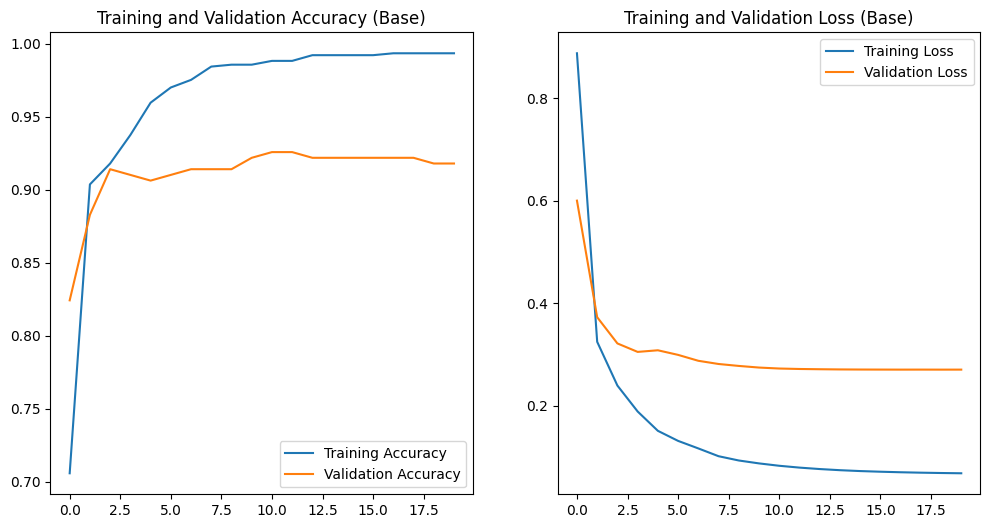

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 967ms/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:01<00:10,  1.43s/it]

1/1 [==============================] - 0s 85ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:01<00:04,  1.22it/s]

1/1 [==============================] - 0s 82ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:03,  1.61it/s]

1/1 [==============================] - 0s 80ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:02<00:02,  1.89it/s]

1/1 [==============================] - 0s 78ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:02<00:01,  2.11it/s]

1/1 [==============================] - 0s 78ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:03<00:00,  2.27it/s]

1/1 [==============================] - 0s 79ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:03<00:00,  2.38it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]



Accuracy of base model on test data: 92.92%
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        49
           1       1.00      1.00      1.00        35
           2       0.98      0.96      0.97        46
           3       0.82      0.93      0.87        45
           4       0.98      0.88      0.93        51

    accuracy                           0.93       226
   macro avg       0.94      0.93      0.93       226
weighted avg       0.93      0.93      0.93       226

    0   1   2   3   4
0  44   0   0   4   1
1   0  35   0   0   0
2   0   0  44   2   0
3   2   0   1  42   0
4   3   0   0   3  45


Activation     Initializer Regularizer  Dropout  Dense_Neurons  \
0  leaky_relu  glorot_uniform        None      0.0            256   

   Accuracy_Score  
0       92.920354

In [11]:
training_results_df = pd.DataFrame(columns=['Activation', 'Initializer', 'Regularizer', 'Dropout', 'Dense_Neurons', 'Accuracy_Score'])

resnet_model = None
i=0
# with mlflow.start_run():
    # mlflow.sklearn.autolog()
for activation in ACTIVATIONS:
    for initializer in INITIALIZERS:
        for regularizer in KERNEL_REGULARIZERS:
            for dropout_rate in DROPOUT_RATE:
                for num_start_cnn_neurons in NUM_START_CNN_NEURONS:
                    for num_dense_neurons in NUM_DENSE_NEURONS:
                        print(f'\n\n{i+1}. Training model with activation = {activation}, initializer = {initializer}, regulizer = {regularizer},  dropout_rate={dropout_rate}, num_start_cnn_neurons={num_start_cnn_neurons} and num_dense_neurons={num_dense_neurons}')
                        print("="*80)

                        resnet_model = create_resnet50_model(activation, initializer, regularizer, dropout_rate, num_dense_neurons)

                        LR_SCHEDULE = tf.keras.optimizers.schedules.ExponentialDecay(
                            initial_learning_rate = INITIAL_LEARNING_RATE,
                            decay_steps = STEPS_PER_EPOCH,
                            decay_rate=LEARNING_RATE_DECAY_FACTOR,
                            staircase=True)

                        resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_SCHEDULE),
                                      loss="sparse_categorical_crossentropy",
                                      metrics=['accuracy'])
                        resnet_model.trainable = True
                        # Make CNN Layer 5 of the ResNet50 model trainable but keep the others locked
                        for layer in resnet_model.layers:
                            if not (("conv5_" in layer.name or "dense_" in layer.name or "global_average_pooling" in layer.name or "dropout_" in layer.name) and "_bn" not in layer.name):
                                layer.trainable = False

                        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
                        checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_resnet50_model_ft_l5.h5", save_best_only=True)

                        history_base = resnet_model.fit(
                                        x=train_ds,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        verbose="auto",
                                        callbacks=[early_stopping_cb, checkpoint_cb],
                                        validation_data=val_ds
                                        # class_weight=None,
                                        # sample_weight=None,
                                        # initial_epoch=0,
                                        # steps_per_epoch=None,
                                        # validation_steps=None,
                                        # validation_batch_size=None,
                                        # validation_freq=1,
                                    )

                        plot_accuracy_loss(history_base)

                        y_true, y_pred = eval_model_on_test(resnet_model, test_ds)
                        score = (accuracy_score(y_true, y_pred)*100)
                        print("\n\nAccuracy of base model on test data: %.2f%%" % score)
                        print(classification_report(y_true, y_pred)) #, target_names=CLASSES
                        print(pd.DataFrame(confusion_matrix(y_true, y_pred)))

                        new_row = {'Activation' : activation, 'Initializer' : initializer, 'Regularizer': regularizer, 'Dropout' : dropout_rate, 'Dense_Neurons' : num_dense_neurons, 'Accuracy_Score' : score}
                        training_results_df.loc[len(training_results_df)] = new_row
                        i += 1

print("="*80)
training_results_df

In [12]:
for layer in resnet_model.layers:
    print(f"{layer.name} trainable={layer.trainable}")

input_2 trainable=False
conv1_pad trainable=False
conv1_conv trainable=False
conv1_bn trainable=False
conv1_relu trainable=False
pool1_pad trainable=False
pool1_pool trainable=False
conv2_block1_1_conv trainable=False
conv2_block1_1_bn trainable=False
conv2_block1_1_relu trainable=False
conv2_block1_2_conv trainable=False
conv2_block1_2_bn trainable=False
conv2_block1_2_relu trainable=False
conv2_block1_0_conv trainable=False
conv2_block1_3_conv trainable=False
conv2_block1_0_bn trainable=False
conv2_block1_3_bn trainable=False
conv2_block1_add trainable=False
conv2_block1_out trainable=False
conv2_block2_1_conv trainable=False
conv2_block2_1_bn trainable=False
conv2_block2_1_relu trainable=False
conv2_block2_2_conv trainable=False
conv2_block2_2_bn trainable=False
conv2_block2_2_relu trainable=False
conv2_block2_3_conv trainable=False
conv2_block2_3_bn trainable=False
conv2_block2_add trainable=False
conv2_block2_out trainable=False
conv2_block3_1_conv trainable=False
conv2_block3_1_b

### **Step 4.4: ResNet50 Model (make ALL layers of the ResNet model trainable)**



1. Training model with activation = leaky_relu, initializer = glorot_uniform, regulizer = None,  dropout_rate=0.0, num_start_cnn_neurons=32 and num_dense_neurons=256
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/20


I0000 00:00:1707825877.473808     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.7305

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 21s 439ms/step - loss: 0.7944 - accuracy: 0.7305 - val_loss: 0.4100 - val_accuracy: 0.8555
Epoch 2/20
24/24 [==============================] - 9s 370ms/step - loss: 0.2927 - accuracy: 0.9089 - val_loss: 0.3384 - val_accuracy: 0.9023
Epoch 3/20
24/24 [==============================] - 9s 375ms/step - loss: 0.2222 - accuracy: 0.9297 - val_loss: 0.3373 - val_accuracy: 0.9062
Epoch 4/20
24/24 [==============================] - 9s 376ms/step - loss: 0.1849 - accuracy: 0.9297 - val_loss: 0.3076 - val_accuracy: 0.9297
Epoch 5/20
24/24 [==============================] - 9s 380ms/step - loss: 0.1559 - accuracy: 0.9557 - val_loss: 0.3075 - val_accuracy: 0.9062
Epoch 6/20
24/24 [==============================] - 8s 355ms/step - loss: 0.1304 - accuracy: 0.9635 - val_loss: 0.3310 - val_accuracy: 0.9062
Epoch 7/20
24/24 [==============================] - 8s 355ms/step - loss: 0.1158 - accuracy: 0.9740 - val_loss: 0.3222 - val_accuracy: 0.8984
Epoch 8/20
24/24

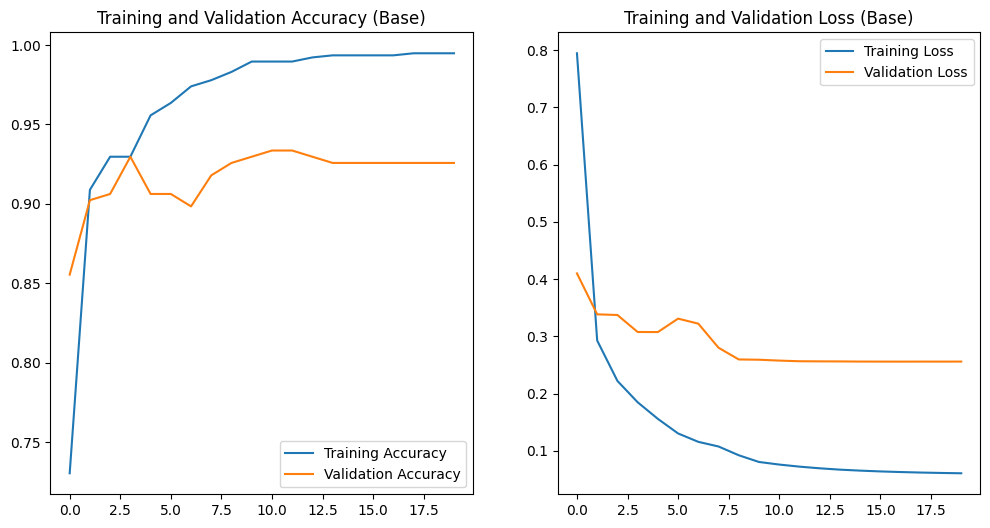

Predicting on Test Data:   0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Predicting on Test Data:  12%|█▎        | 1/8 [00:01<00:10,  1.53s/it]

1/1 [==============================] - 0s 86ms/step


Predicting on Test Data:  25%|██▌       | 2/8 [00:01<00:05,  1.17it/s]

1/1 [==============================] - 0s 84ms/step


Predicting on Test Data:  38%|███▊      | 3/8 [00:02<00:03,  1.56it/s]

1/1 [==============================] - 0s 88ms/step


Predicting on Test Data:  50%|█████     | 4/8 [00:02<00:02,  1.86it/s]

1/1 [==============================] - 0s 78ms/step


Predicting on Test Data:  62%|██████▎   | 5/8 [00:03<00:01,  2.10it/s]

1/1 [==============================] - 0s 79ms/step


Predicting on Test Data:  75%|███████▌  | 6/8 [00:03<00:00,  2.27it/s]

1/1 [==============================] - 0s 79ms/step


Predicting on Test Data:  88%|████████▊ | 7/8 [00:03<00:00,  2.40it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]



Accuracy of base model on test data: 94.25%
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        49
           1       0.97      1.00      0.99        35
           2       0.98      0.93      0.96        46
           3       0.86      0.93      0.89        45
           4       0.98      0.94      0.96        51

    accuracy                           0.94       226
   macro avg       0.94      0.95      0.94       226
weighted avg       0.94      0.94      0.94       226

    0   1   2   3   4
0  45   0   0   3   1
1   0  35   0   0   0
2   0   1  43   2   0
3   2   0   1  42   0
4   1   0   0   2  48


Activation     Initializer Regularizer  Dropout  Dense_Neurons  \
0  leaky_relu  glorot_uniform        None      0.0            256   

   Accuracy_Score  
0       94.247788

In [11]:
training_results_df = pd.DataFrame(columns=['Activation', 'Initializer', 'Regularizer', 'Dropout', 'Dense_Neurons', 'Accuracy_Score'])

resnet_model = None
i=0
# with mlflow.start_run():
    # mlflow.sklearn.autolog()
for activation in ACTIVATIONS:
    for initializer in INITIALIZERS:
        for regularizer in KERNEL_REGULARIZERS:
            for dropout_rate in DROPOUT_RATE:
                for num_start_cnn_neurons in NUM_START_CNN_NEURONS:
                    for num_dense_neurons in NUM_DENSE_NEURONS:
                        print(f'\n\n{i+1}. Training model with activation = {activation}, initializer = {initializer}, regulizer = {regularizer},  dropout_rate={dropout_rate}, num_start_cnn_neurons={num_start_cnn_neurons} and num_dense_neurons={num_dense_neurons}')
                        print("="*80)

                        resnet_model = create_resnet50_model(activation, initializer, regularizer, dropout_rate, num_dense_neurons)

                        LR_SCHEDULE = tf.keras.optimizers.schedules.ExponentialDecay(
                            initial_learning_rate = INITIAL_LEARNING_RATE,
                            decay_steps = STEPS_PER_EPOCH,
                            decay_rate=LEARNING_RATE_DECAY_FACTOR,
                            staircase=True)

                        resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_SCHEDULE),
                                      loss="sparse_categorical_crossentropy",
                                      metrics=['accuracy'])
                        resnet_model.trainable = True

                        early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
                        checkpoint_cb = keras.callbacks.ModelCheckpoint(PRODUCT_CATEGORY+"_resnet50_model_ft_all.h5", save_best_only=True)

                        history_base = resnet_model.fit(
                                        x=train_ds,
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        verbose="auto",
                                        callbacks=[early_stopping_cb, checkpoint_cb],
                                        validation_data=val_ds
                                        # class_weight=None,
                                        # sample_weight=None,
                                        # initial_epoch=0,
                                        # steps_per_epoch=None,
                                        # validation_steps=None,
                                        # validation_batch_size=None,
                                        # validation_freq=1,
                                    )

                        plot_accuracy_loss(history_base)

                        y_true, y_pred = eval_model_on_test(resnet_model, test_ds)
                        score = (accuracy_score(y_true, y_pred)*100)
                        print("\n\nAccuracy of base model on test data: %.2f%%" % score)
                        print(classification_report(y_true, y_pred)) #, target_names=CLASSES
                        print(pd.DataFrame(confusion_matrix(y_true, y_pred)))

                        new_row = {'Activation' : activation, 'Initializer' : initializer, 'Regularizer': regularizer, 'Dropout' : dropout_rate, 'Dense_Neurons' : num_dense_neurons, 'Accuracy_Score' : score}
                        training_results_df.loc[len(training_results_df)] = new_row
                        i += 1

print("="*80)
training_results_df

In [28]:
training_results_df

Activation     Initializer Regularizer  Dropout  Dense_Neurons  \
0  leaky_relu  glorot_uniform        None      0.0            256   

   Accuracy_Score  
0       95.132743

In [32]:
for layer in resnet_model.layers:
    print(f"{layer.name} trainable={layer.trainable}")

input_8 trainable=True
conv1_pad trainable=True
conv1_conv trainable=True
conv1_bn trainable=True
conv1_relu trainable=True
pool1_pad trainable=True
pool1_pool trainable=True
conv2_block1_1_conv trainable=True
conv2_block1_1_bn trainable=True
conv2_block1_1_relu trainable=True
conv2_block1_2_conv trainable=True
conv2_block1_2_bn trainable=True
conv2_block1_2_relu trainable=True
conv2_block1_0_conv trainable=True
conv2_block1_3_conv trainable=True
conv2_block1_0_bn trainable=True
conv2_block1_3_bn trainable=True
conv2_block1_add trainable=True
conv2_block1_out trainable=True
conv2_block2_1_conv trainable=True
conv2_block2_1_bn trainable=True
conv2_block2_1_relu trainable=True
conv2_block2_2_conv trainable=True
conv2_block2_2_bn trainable=True
conv2_block2_2_relu trainable=True
conv2_block2_3_conv trainable=True
conv2_block2_3_bn trainable=True
conv2_block2_add trainable=True
conv2_block2_out trainable=True
conv2_block3_1_conv trainable=True
conv2_block3_1_bn trainable=True
conv2_block3_

In [54]:
num_mismatches, mismatch_tensor_indexes = get_mismatches(y_true, y_pred, BATCH_SIZE)
print(f"Number of mismatches = {num_mismatches}")
mismatch_tensor_indexes

Number of mismatches = 81


{0: [(5, 5),
  (12, 12),
  (19, 19),
  (21, 21),
  (22, 22),
  (25, 25),
  (27, 27),
  (30, 30)],
 1: [(8, 40),
  (9, 41),
  (11, 43),
  (13, 45),
  (15, 47),
  (16, 48),
  (17, 49),
  (19, 51),
  (20, 52),
  (21, 53),
  (24, 56),
  (29, 61),
  (30, 62),
  (31, 63)],
 2: [(0, 64),
  (11, 75),
  (15, 79),
  (16, 80),
  (21, 85),
  (22, 86),
  (23, 87),
  (24, 88),
  (26, 90),
  (27, 91),
  (28, 92)],
 3: [(0, 96),
  (3, 99),
  (6, 102),
  (9, 105),
  (10, 106),
  (13, 109),
  (16, 112),
  (17, 113),
  (20, 116),
  (21, 117),
  (22, 118),
  (24, 120),
  (29, 125),
  (31, 127)],
 4: [(0, 128),
  (1, 129),
  (4, 132),
  (5, 133),
  (9, 137),
  (12, 140),
  (18, 146),
  (22, 150),
  (27, 155),
  (28, 156),
  (29, 157)],
 5: [(1, 161),
  (6, 166),
  (10, 170),
  (15, 175),
  (16, 176),
  (19, 179),
  (21, 181),
  (25, 185),
  (26, 186),
  (29, 189)],
 6: [(1, 193),
  (2, 194),
  (5, 197),
  (16, 208),
  (20, 212),
  (24, 216),
  (25, 217),
  (26, 218),
  (27, 219),
  (28, 220),
  (31, 223)],

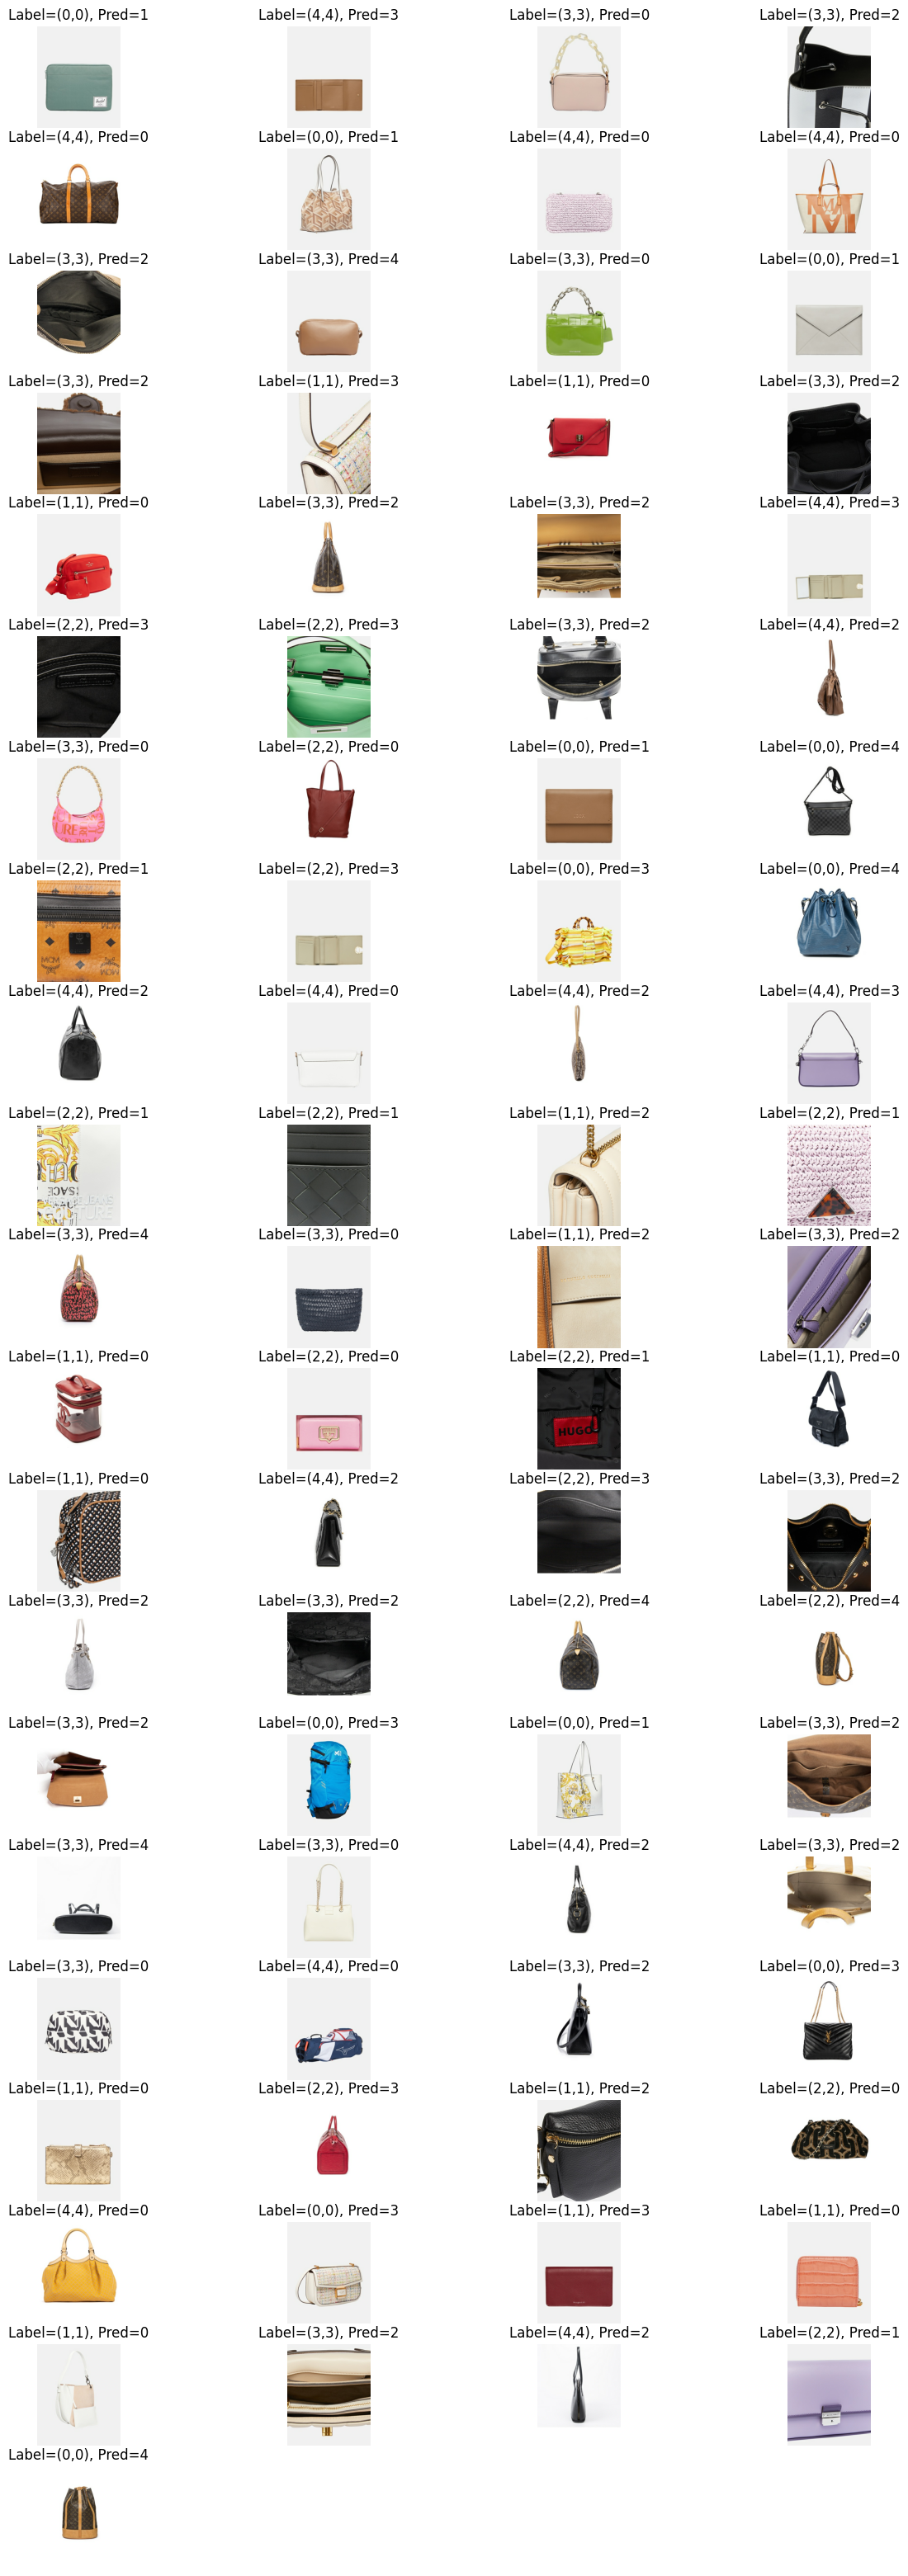

In [55]:
show_mismatches(test_ds, mismatch_tensor_indexes, num_mismatches)

In [ ]:
def show_grad_cam(model, num_classes, orig):
    model_gc = GradCAM(model=model, classIdx=num_classes)

    heatmap = model_gc.compute_heatmap(image, verbose=True)
    # resize the resulting heatmap to the original input image dimensions
    # overlay heatmap on top of the image
    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]),
                        interpolation=cv2.INTER_CUBIC)
    (heatmap, output) = model_gc.overlay_heatmap(heatmap, orig, alpha=0.45)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    f, ax = plt.subplots(1,2, figsize=(20, 10))

    plt.axis('off');
    ax[0].imshow(orig);
    # ax[1].imshow(heatmap);
    ax[1].imshow(output);
    [axi.set_axis_off() for axi in ax.ravel()]

In [56]:
def show_mismatches_grad_cam(model, test_ds, num_classes, mismatch_tensor_indexes, num_mismatches):
# def show_mismatches(test_ds, mismatch_tensor_indexes, num_mismatches):
    i=0
    total_tensor_batches = math.ceil(len(y_pred)/BATCH_SIZE)
    tensor_batch = 0
    model_gc = GradCAM(model=model, classIdx=num_classes)
    plt.figure(figsize=(15, (math.ceil(num_mismatches//20)*20)))
    for images, labels in test_ds.take(total_tensor_batches):
      if mismatch_tensor_indexes.get(tensor_batch) is not None:
        for tensor_batch_mismatches in mismatch_tensor_indexes.get(tensor_batch):
          image = images[tensor_batch_mismatches[0]].numpy().astype("uint8")

          heatmap = model_gc.compute_heatmap(image, verbose=True)
          # resize the resulting heatmap to the original input image dimensions
          # overlay heatmap on top of the image
          # heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]),
          #                     interpolation=cv2.INTER_CUBIC)
          (heatmap, output) = model_gc.overlay_heatmap(heatmap, image, alpha=0.45)
          heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
          output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

          ax = plt.subplot(math.ceil(num_mismatches/2), 2, i + 1)
          plt.imshow(image)
          plt.title(f"Label=({labels[tensor_batch_mismatches[0]]},{y_true[tensor_batch_mismatches[1]]}), Pred={y_pred[tensor_batch_mismatches[1]]}")
          plt.axis("off")
          i += 1

          ax = plt.subplot(math.ceil(num_mismatches/2), 2, i + 1)
          plt.imshow(output)
          plt.title(f"Label=({labels[tensor_batch_mismatches[0]]},{y_true[tensor_batch_mismatches[1]]}), Pred={y_pred[tensor_batch_mismatches[1]]}")
          plt.axis("off")
          i += 1

      tensor_batch += 1

In [ ]:
show_mismatches_grad_cam(resnet_model, test_ds, 5, mismatch_tensor_indexes, 3)